In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [2]:
env = gym.make("MountainCar-v0")

TIME_LIMIT = 400
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

s = env.reset()
print(f"Initial state: {s}")

Action space: Discrete(3)
Observation space: Box(2,)
Initial state: [-0.42119291  0.        ]


In [3]:
x_high, v_high = env.observation_space.high
x_low, v_low = env.observation_space.low

x_deepest = -0.5

n_actions = env.action_space.n - 1

print(x_high, x_low)
print(v_high, v_low)

n_actions

0.6 -1.2
0.07 -0.07


2

In [4]:
real_states = np.linspace(v_low, v_high, 100)
n_states = len(real_states)
print(real_states)

[-0.07       -0.06858586 -0.06717172 -0.06575758 -0.06434343 -0.06292929
 -0.06151515 -0.06010101 -0.05868687 -0.05727273 -0.05585859 -0.05444444
 -0.0530303  -0.05161616 -0.05020202 -0.04878788 -0.04737374 -0.0459596
 -0.04454545 -0.04313131 -0.04171717 -0.04030303 -0.03888889 -0.03747475
 -0.03606061 -0.03464646 -0.03323232 -0.03181818 -0.03040404 -0.0289899
 -0.02757576 -0.02616162 -0.02474747 -0.02333333 -0.02191919 -0.02050505
 -0.01909091 -0.01767677 -0.01626263 -0.01484848 -0.01343434 -0.0120202
 -0.01060606 -0.00919192 -0.00777778 -0.00636364 -0.00494949 -0.00353535
 -0.00212121 -0.00070707  0.00070707  0.00212121  0.00353535  0.00494949
  0.00636364  0.00777778  0.00919192  0.01060606  0.0120202   0.01343434
  0.01484848  0.01626263  0.01767677  0.01909091  0.02050505  0.02191919
  0.02333333  0.02474747  0.02616162  0.02757576  0.0289899   0.03040404
  0.03181818  0.03323232  0.03464646  0.03606061  0.03747475  0.03888889
  0.04030303  0.04171717  0.04313131  0.04454545  0.04

In [5]:
policy = np.ones((n_states, n_actions), dtype="float") / n_actions
# policy

In [6]:
def get_state_idx(val):
#     print("val: ", val)
    mmin = min(real_states, key=lambda x: abs(x - val))
#     print("min: ", mmin)
    result = np.where(real_states == mmin)
#     result = np.where(np.isclose(real_states, val, rtol=1.e-2, atol=1.e-6))
#     print("result: ", result)
    _idx = result[0][0]
    return _idx

import math

def generate_session(policy, t_max=int(10**4)):
    states, actions = [], []
    total_reward = 0.

    x, v = env.reset()
    
    _sign = v > 0
    
    for t in range(t_max):
        
        s_idx = get_state_idx(v)
        a = np.random.choice(n_actions, p=policy[s_idx])
        
        new_s, r, done, info = env.step(0 if a == 0 else 2)
        
        states.append(s_idx)
        
        actions.append(a)
        
        x, v = new_s
        
        new_sign = v > 0
        
#         r1 = 1 if (x < x_deepest and v < 0) or (x > x_deepest and v > 0) else -1
        
#         r2 = 0

#         r2 = 1 if _sign == new_sign else -5

#         if v < 0:
#             _r = (abs(v * 10) + math.exp(0.1 / (0.6 - x))) if _sign == new_sign else -5
#         else:
#             _r = (abs(v * 5) + math.exp(0.1 / (0.6 - x))) if _sign == new_sign else -10
            
#         _r = (abs(v * 10) + 1 / (0.6 - x)) if _sign == new_sign else -1
        
#         r2 = math.exp(abs(v * 10)) + math.exp(0.1 / (0.6 - x))) if _sign == new_sign else -1
        r2 = 1 if _sign == new_sign else -10

        total_reward += r + r2

        _sign = new_sign
        
        if done:
            break
            
    return states, actions, total_reward

In [7]:
# _ss = generate_session(policy, t_max=10)

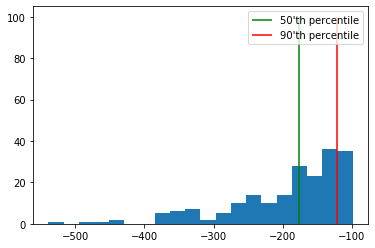

In [8]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [9]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_mask = np.asarray(rewards_batch) >= reward_threshold
    elite_states = np.asarray(states_batch)[elite_mask]
    elite_actions = np.asarray(actions_batch)[elite_mask]

    return np.concatenate(elite_states), np.concatenate(elite_actions)

In [10]:
def update_policy(elite_states, elite_actions):
    new_policy = np.zeros([n_states, n_actions])
    
    for idx, s in enumerate(elite_states):
        new_policy[s, elite_actions[idx]] += 1.
        
    never_visited_mask = new_policy.sum(axis=1) == 0.
    
    new_policy[never_visited_mask] = 1.

    new_policy /= new_policy.sum(axis=1)[:, None]
    
    return new_policy

In [11]:
def show_progress(rewards_batch, log, percentile, reward_range=[-100, +10]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    display.clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [12]:
policy = np.ones((n_states, n_actions), dtype="float") / n_actions

mean reward = -35.860, threshold=-33.000


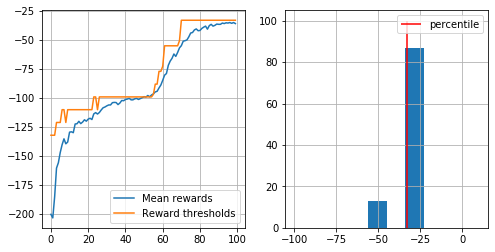

In [13]:
n_sessions = 100  # sample this many sessions
percentile = 80  # take this percent of session with highest rewards
learning_rate = 0.5  # add this thing to all counts for stability

log = []

for i in range(100):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    #  [ < generate a list of n_sessions new sessions > ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    if i+1 % 5:
        learning_rate *= 0.99
    
    elite_states, elite_actions = select_elites(
        states_batch, 
        actions_batch, 
        rewards_batch, 
        percentile=percentile
    )

    new_policy = update_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1-learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [20]:
import time

x, v = env.reset()

step = 0

while True:
    step += 1
    
    s_idx = get_state_idx(v)
    
    a = np.random.choice(n_actions, p=policy[s_idx])
    
    new_s, r, done, info = env.step(0 if a == 0 else 2)
    
    x, v = new_s
    
    display.clear_output()
    env.render()
#     time.sleep(1)
    
    if done:
        break

print(f"Spent: {step}")

Spent: 200


In [21]:
policy

array([[5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000015e-01, 4.99999985e-01],
       [4.99999031e-01, 5.00000969e-01],
       [4.99966174e-01, 5.00033826e-01],
       [5.00049804e-01, 4.99950196e-01],
       [4.99871512e-01, 5.00128488e-01],
       [4.99997825e-01, 5.00002175e-01],
       [5.00166390e-01, 4.99833610e-01],
       [4.99712298e-01, 5.00287702e-01],
       [5.00202258e-01, 4.99797742e-01],
       [4.92961488e-01, 5.07038512e-01],
       [4.75655563e-01, 5.24344437e-01],
       [4.59111226e-01, 5.40888774e-01],
       [3.47910435e-01, 6.52089565e-01],
       [2.94011445e-01, 7.05988555e-01],
       [3.43201475e-01, 6.56798525e-01],
       [2.59906429e-01, 7.40093571e-01],
       [1.02911973e-05, 9.99989709e-01],
       [4.74678636e-01, 5.25321364e-01],
       [6.25705346e-01, 3.74294654e-01],
       [6.74131780e-01, 3.25868220e-01],
       [7.61498370e-01, 2.38501630e-01],
       [9.859013

In [22]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(
    gym.make("MountainCar-v0"), 
    directory="videos", 
    force=True
)

sessions = [generate_session(policy, 1000) for _ in range(5)]
env.close()

In [17]:
# # show video
# from IPython.display import HTML
# import os

# video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

# HTML("""
#      <video width="640" height="480" controls><source src="{}" type="video/mp4">
# </video>
# """.format("./videos/"+video_names[0]))  # this may or may not be _last_ video. Try other indices